In [1]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

load_dotenv()

model = ChatOpenAI(model="gpt-4o")

In [2]:
search_tool = TavilySearchResults(max_results=4)

tools = [search_tool]

memory = MemorySaver()

In [3]:
llm_with_tools = model.bind_tools(tools=tools)

In [4]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)


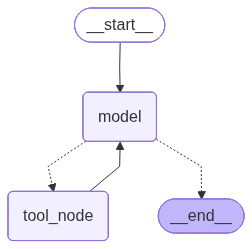

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [6]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='8d144e24-663d-4fae-974e-cd0f56838380'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OUE6VJXgretm4b9NUrJHMt7K', 'function': {'arguments': '{"query":"next SpaceX launch schedule"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 87, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CLQsGEJ3XzwXvy0DleLVvpExN3qXG', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c7525962-576a-4bf4-a5d1-1422d42b20f8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query'

In [7]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '7c1351a4-1e2b-41c4-a61e-cd07c7895172', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='73aa50f2-cea6-4114-8dea-30ed7fad3212')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '3c8dd037-bbc6-4217-b204-3feb2d513495', 'metadata': {'thread_id': 8, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:266950e8-7e40-f750-f24c-c1b35eb7a1d7'}, 'parent_ids': ['7c1351a4-1e2b-41c4-a61e-cd07c7895172']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='When is the next spa